In [1]:
import numpy as np
from scipy.optimize import differential_evolution

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

import jax
import jax.random as jrd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.optimize import minimize

import numpy as np
from scipy.linalg import expm

# Generate Objective Function with Random Data

## Generate Random Data

### Random Initial State

In [2]:
# initial state |0>
def generate_random_initial_state(num_qubit):
    # Generate a random complex vector of length 2**num_qubit
    vector = np.random.randn(2**num_qubit) + 1j * np.random.randn(2**num_qubit)
    
    # Normalize to unit length
    unit_vector = vector / np.linalg.norm(vector)
    
    return unit_vector

# Example
num_qubit = 1
initial_state = generate_random_initial_state(num_qubit)
print(initial_state)

[ 0.74097869-0.42372669j -0.50712827-0.1192778j ]


### Random Observable

In [3]:
# Function to generate a random Hermitian matrix of a given size
def generate_random_observable(num_qubit):
    A = np.random.randn(2**num_qubit, 2**num_qubit) 
    A = A + 1j * np.random.randn(2**num_qubit, 2**num_qubit)  # Random complex matrix
    M = (A + A.conj().T) / 2  # Hermitian part (A + A†)/2
    return M

# Example
num_qubit = 1
M = generate_random_observable(num_qubit) # Define an example observable matrix (Hermitian)
print(M)

[[ 0.33761891+0.j         -1.03213941-0.31878683j]
 [-1.03213941+0.31878683j -0.3299689 +0.j        ]]


### Generate Random Hermitian Generators

#### Method 1: Generate Specific Hermitian Generators Using Pauli Matrices (Equdistant Frequency)

In [4]:
# Define Pauli matrices and put them into a dictionary
pauli_matrices = {
    'X': np.array([[0, 1], [1, 0]]),
    'Y': np.array([[0, -1j], [1j, 0]]),
    'Z': np.array([[1, 0], [0, -1]]),
    'I': np.array([[1, 0], [0, 1]])
}

# Create a function to compute the tensor product of multiple Pauli matrices
def kron_product_from_words(words):
    # Get the first Pauli matrix
    result = pauli_matrices[words[0]]
    
    # Perform tensor product operation on the remaining matrices
    for word in words[1:]:
        result = np.kron(result, pauli_matrices[word])
    
    return result

# Example: Compute X ⊗ Z ⊗ I
words = ['X', 'Z', 'I']
result_matrix = kron_product_from_words(words)

print("Resulting matrix for X ⊗ Z ⊗ I:")
print(result_matrix)

Resulting matrix for X ⊗ Z ⊗ I:
[[ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]]


In [5]:
# Define the function to generate special generators
def generate_special_generator(num_qubit, num_strings):
    # Generate a random words_0
    words_0 = [np.random.choice(['X', 'Y', 'Z']) for _ in range(num_qubit)]

    # Generate num_strings Pauli strings
    words_list = []

    for _ in range(num_strings):
        # Initialize a list with all 'I'
        words = ['I'] * num_qubit

        for i in range(num_qubit):
            # Randomly choose from ['I'] or words_0[i] at position i
            words[i] = np.random.choice(['I', words_0[i]])

        words_list.append(words)
  
    # Initialize the final generator
    generator = np.zeros((2**num_qubit, 2**num_qubit), dtype=complex)

    # For each word in words_list, compute its tensor product matrix and accumulate
    for words in words_list:
        sign = np.random.choice([1, -1])  # Generate a random sign (+ or -)
        generator += sign * kron_product_from_words(words)  # Add the sign and accumulate

    return generator, words_list

# Example: Generate 6 Pauli strings with length 2
num_qubit = 2
num_strings = 6
generator, pauli_strings = generate_special_generator(num_qubit, num_strings)

# Output the generated Pauli strings and their tensor products
print(f"Generator: \n{generator}\n")
for i, string in enumerate(pauli_strings):
    print(f"Pauli String {i+1}: {string}")

Generator: 
[[ 1.+0.j -1.+0.j  0.+1.j  0.-1.j]
 [-1.+0.j  1.+0.j  0.-1.j  0.+1.j]
 [ 0.-1.j  0.+1.j  1.+0.j -1.+0.j]
 [ 0.+1.j  0.-1.j -1.+0.j  1.+0.j]]

Pauli String 1: ['I', 'X']
Pauli String 2: ['Y', 'I']
Pauli String 3: ['I', 'I']
Pauli String 4: ['Y', 'X']
Pauli String 5: ['Y', 'X']
Pauli String 6: ['Y', 'X']


In [6]:
# Generate multiple generators and store them in a dictionary
def generate_special_Hermitian_generators(num_qubit, num_strings, num_generators):
    generators_dict = {}

    for i in range(num_generators):
        generator, pauli_strings = generate_special_generator(num_qubit, num_strings)
        generators_dict[f"Generator_{i}"] = {
            'H': generator,
            'Pauli Strings': pauli_strings
        }

    return generators_dict

# Example: Generate 3 generators, each consisting of 6 Pauli strings, with each Pauli string of length 2
num_qubit = 3
num_strings = 6
num_generators = 3

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)

# Output all generated generators and their Pauli strings
for gen_key, gen_info in generators_dict.items():
    print(f"{gen_key}:")
    print(f"  Generator H: \n {gen_info['H']}")
    for i, string in enumerate(gen_info['Pauli Strings']):
        print(f"  Pauli String {i+1}: {string}")
    print("\n")

Generator_0:
  Generator H: 
 [[-1.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  3.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j  3.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j  3.+0.j]]
  Pauli String 1: ['I', 'I', 'X']
  Pauli String 2: ['Z', 'I', 'X']
  Pauli String 3: ['I', 'Z', 'I']
  Pauli String 4: ['Z', 'I', 'X']
  Pauli String 5: ['Z', 'I', 'I']
  Pauli String 6: ['I', 'I', 'I']


Generator_1:
  Generator H: 
 [[ 1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  3.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j]
 [ 1.+0.j  0.+0.j  1.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0

#### Method 2: Completely Random Hermitian Generators (Non-Equadistant Frequency)

In [7]:
# Define the function to generate m completely random Hermitian matrices H
def generate_random_Hermitian_generators(num_qubit, num_generators):
    generators_dict = {}

    for i in range(num_generators):
        A = np.random.randn(2**num_qubit, 2**num_qubit) + 1j * np.random.randn(2**num_qubit, 2**num_qubit)
        generator = (A + A.conj().T) / 2  # Ensure the generated matrix is Hermitian
        
        # Store the generated matrix in the dictionary
        generators_dict[f"Generator_{i}"] = {
            'H': generator
        }

    return generators_dict

# Example: Generate 3 random matrices of size 2 qubits
num_qubit = 1
num_generators = 3

generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)

# Output all generated random matrices
for gen_key, gen_info in generators_dict.items():
    print(f"{gen_key}:")
    print(f"  Generator H: \n {gen_info['H']}")
    print("\n")

Generator_0:
  Generator H: 
 [[ 0.20373273+0.j          0.18532113-0.78097685j]
 [ 0.18532113+0.78097685j -0.46785278+0.j        ]]


Generator_1:
  Generator H: 
 [[1.23888215+0.j         1.69659379-0.02614667j]
 [1.69659379+0.02614667j 0.79979219+0.j        ]]


Generator_2:
  Generator H: 
 [[-1.20630569+0.j         -0.78944303-0.21502369j]
 [-0.78944303+0.21502369j  0.62922999+0.j        ]]




## Define the Objective Function

In [8]:
def expectation_value(initial_state, observable, generators_dict, theta):
    # Apply the unitary evolution to the initial state
    state = initial_state
    
    for i, gen_key in enumerate(generators_dict):
        # Access the Hamiltonian for the current generator
        H_j = generators_dict[gen_key]['H']
        
        # Compute the unitary U_j(theta_j) = exp(i H_j theta_j)
        U_j = expm(1.j * H_j * theta[i])
        
        # Apply the unitary to the state
        state = U_j @ state

    # Compute the expectation value <psi|M|psi>
    expectation = np.dot(state.conj().T, np.dot(observable, state))
    
    return np.real(expectation)

# Example：
num_qubit = 2
initial_state = generate_random_initial_state(num_qubit)
observable = generate_random_observable(num_qubit)
num_generators = 3
generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)
num_strings = 6
generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)

theta = np.random.rand(num_generators)*2*np.pi

expectation = expectation_value(initial_state, observable, generators_dict, theta)
print("Expectation value:", expectation)


Expectation value: -0.18476326215583475


## Algorithm Preparation Phase


### Calculate omega_set for Each Hermitian Generator

In [9]:
def compute_omega_set(H, threshold=1e-4, integer_threshold=1e-7):
    # Compute the eigenvalues of matrix H
    eigenvalues = np.linalg.eigvals(H)
    
    # Initialize a set to store all differences of eigenvalues greater than the threshold
    omega_set = set()
    N = len(eigenvalues)
    
    # Traverse all pairs of eigenvalues and compute and store their differences
    for i in range(N):
        for j in range(i+1, N):
            diff = abs(eigenvalues[i] - eigenvalues[j])
            if diff > threshold:
                omega_set.add(diff)
    
    # Inner function: Merge close values
    def clean_omega_set(omega_set, threshold, integer_threshold):
        # Sort omega_set for easier merging of close values
        sorted_omega_set = sorted(omega_set)
        
        # Store the merged results
        merged_set = []
        
        # Traverse each value and merge close values
        for value in sorted_omega_set:
            # If merged_set is empty or the difference between the current value and the last added value is greater than the threshold, add directly
            if not merged_set or abs(value - merged_set[-1]) > threshold:
                # If the current value is close to an integer, replace it with the nearest integer
                if np.isclose(value, round(value), atol=integer_threshold):
                    value = round(value)  # Replace with the nearest integer
                merged_set.append(value)
        
        return merged_set
    
    # Call the clean_omega_set function to merge close differences and handle close-to-integer cases
    omega_set = clean_omega_set(omega_set, threshold, integer_threshold)
    
    return omega_set

def compute_all_omega_set(generators_dict):
    # Apply compute_omega_set to each H matrix in the dictionary and add the result back to the dictionary
    for _, gen_info in generators_dict.items():
        H = gen_info['H']
        omega_set = compute_omega_set(H)  # Compute omega_set
        gen_info['omega_set'] = omega_set  # Add omega_set to the dictionary
        
    return generators_dict


# Example: Generate 3 generators, each consisting of 6 Pauli strings, with each Pauli string of length 2
num_qubit = 2
num_strings = 3
num_generators = 3

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)
generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)
generators_dict = compute_all_omega_set(generators_dict)

# Print the results
for gen_key, gen_info in generators_dict.items():
    print(f"{gen_key}:")
    # print(f"  Generator H: \n {gen_info['H']}")
    print(f"  Omega set: {gen_info['omega_set']}")
    # for i, string in enumerate(gen_info['Pauli Strings']):
    #     print(f"  Pauli String {i+1}: {string}")
    print("\n")


Generator_0:
  Omega set: [0.8073089670272522, 0.9225504215007079, 1.8782707818061088, 2.6855797488333613, 2.8008212033068167, 3.6081301703340687]


Generator_1:
  Omega set: [1.2082107039414458, 1.7304876221081988, 1.8819570262479406, 2.9386983260496446, 3.0901677301893864, 4.820655352297585]


Generator_2:
  Omega set: [1.0908791230686594, 1.144760268554112, 2.2356393916227715, 2.490335880886626, 3.5812150039552852, 4.725975272509397]




### Calculate the Optimal Interpolation Points and Inverse of Interpolation Matrices for Each Hermitian Generator

In [10]:
# Interpolation matrix generation function
def interp_matrix(interp_points, Omegas):
    r = len(Omegas)
    return np.array([[1/np.sqrt(2)] + [func(Omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)] for x in interp_points])

# Mean Squared Error (MSE) function
def mse(interp_points, Omegas):
    # Create interpolation matrix
    A = interp_matrix(interp_points, Omegas)
    
    # Regularize the matrix
    regularized_matrix = A.T @ A + 1e-6 * np.eye(A.shape[1])  # Add a small regularization term to avoid singular matrix
    
    # Return the trace of the inverse of the matrix
    return np.trace(np.linalg.inv(regularized_matrix))

# Define the optimization function
def optimal_interp_points(Omegas): 
    r = len(Omegas)

    # Define the bounds for the interpolation points
    # bounds = [(-1e6, 1e6) for _ in range(2 * r + 1)]  # This is a loose boundary range
    bounds = [(0, 2*np.pi) for _ in range(2 * r + 1)]

    # Use differential evolution for optimization
    result_mse = differential_evolution(mse, bounds, args=(Omegas,), strategy='best1bin', maxiter=1000)

    opt_mse = result_mse.fun

    # Get the optimized interpolation points
    opt_interp_points = sorted(result_mse.x)

    # Return the optimized interpolation points and the inverse of the corresponding interpolation matrix
    return opt_mse, opt_interp_points, np.linalg.inv(interp_matrix(opt_interp_points, Omegas))

def get_all_optimal_interp_points(generators_dict):
    """
    Apply optimal_interp_points to each omega_set in the dictionary and add the results to the dictionary
    :param generators_dict: Dictionary storing H_final and omega_set
    :return: Updated dictionary containing optimization results
    """
    # Traverse each item in the dictionary
    for key, value in generators_dict.items():
        # Get the current omega_set
        omega_set = value["omega_set"]
        
        # Call the optimal_interp_points function for optimization
        opt_mse, opt_interp_points, inverse_interp_matrix = optimal_interp_points(omega_set)
        
        # Store the optimization results in the dictionary
        generators_dict[key]["opt_mse"] = opt_mse
        generators_dict[key]["opt_interp_points"] = opt_interp_points
        generators_dict[key]["inverse_interp_matrix"] = inverse_interp_matrix
    
    return generators_dict

In [11]:
# Example: Apply the optimization function
num_qubit = 3
num_strings = 1
num_generators = 1

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)
# generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)
generators_dict = compute_all_omega_set(generators_dict)

generators_dict = get_all_optimal_interp_points(generators_dict)

# Print the results
for key, value in generators_dict.items():
    print(f"{key}:")
    print(f"Minimal MSE value: {value['opt_mse']}")
    print(f"Optimized interpolation points: {value['opt_interp_points']}")
    print(f"Inverse of interpolation matrix: \n{value['inverse_interp_matrix']}")
    print("-" * 50)

Generator_0:
Minimal MSE value: 1.999998666667556
Optimized interpolation points: [0.8053864936702988, 4.9941766956335005, 6.0413742457952075]
Inverse of interpolation matrix: 
[[ 0.47140452  0.47140452  0.47140452]
 [-0.026644   -0.56356699  0.59021099]
 [ 0.66613403 -0.3561414  -0.30999263]]
--------------------------------------------------


## OICD Algorithm

In [12]:
'''
The oicd algorithm is as follows:
'''

def construct_Es_inv(s, Omegas):
    """
    Construct the block diagonal matrix E_s^{-1}, where each block is B_i^T, and B_i is a rotation matrix.
    
    Parameters:
    s -- Scalar, the scale of the rotation angle.
    Omegas -- List, containing the values of Omega_i.
    
    Returns:
    E_s_inv -- The constructed block diagonal matrix E_s^{-1}.
    """
    # Calculate the rotation matrix B_i^T
    num_blocks = len(Omegas) + 1  # The first block is a 1x1 matrix [1], and each subsequent block is a 2x2 matrix
    total_size = num_blocks * 2 - 1  # Calculate the total size
    
    # Initialize a zero matrix of size total_size x total_size
    E_s_inv = np.zeros((total_size, total_size))
    
    # Set the first 1x1 block matrix
    E_s_inv[0, 0] = 1
    
    # Fill the subsequent rotation matrix blocks B_i^T
    for i, Omega_i in enumerate(Omegas):
        # Construct each B_i
        B_i = np.array([[np.cos(Omega_i * s), np.sin(Omega_i * s)],
                        [-np.sin(Omega_i * s), np.cos(Omega_i * s)]])
        # Fill B_i^T into the matrix E_s_inv
        E_s_inv[2*i+1:2*i+3, 2*i+1:2*i+3] = B_i.T
    
    return E_s_inv


def oicd(f, generators_dict, initial_point, num_iterations, sigma,
                             opt_goal='min', 
                             cyclic_mode=True, 
                             subproblem_iter=20,
                             ):
    
    theta = initial_point
    best_point = theta
    best_value = f(theta)
    function_values = [best_value]
    hat_f_value = best_value
    hat_function_values = [best_value]

    print("-"*100)
    
    t = trange(num_iterations, desc="Bar desc", leave=True)
    m = len(theta)
    for i in t:
        if cyclic_mode:
            j = i % m
        else:
            j = np.random.choice(range(m))

        theta_old = theta.copy()

        interp_points = generators_dict[f'Generator_{j}']["opt_interp_points"]
        inv_A = generators_dict[f'Generator_{j}']['inverse_interp_matrix']
        Omegas = generators_dict[f'Generator_{j}']['omega_set']

        shift = theta[j] - interp_points[0]
        interp_points += shift
        E_s_inv = construct_Es_inv(shift, Omegas)
        
        fun_vals = [hat_f_value]
        for point in interp_points[1:]:
            theta_old[j] = point
            fun_val = f(theta_old) + np.random.randn() * sigma
            fun_vals.append(fun_val)
        fun_vals = np.array(fun_vals)

        hat_z = E_s_inv @ (inv_A @ fun_vals)

        # Define the calculation of f(x), including the calculation of t(x)
        def hat_f(x): # appr_single_var_fun
            # Directly add 1 / np.sqrt(2) to each value when calculating t_x
            r= len(Omegas)
            t_x = np.array([1 / np.sqrt(2)] + [func(Omegas[k] * x).item() for k in range(r) for func in (np.cos, np.sin)])
            return np.dot(t_x, hat_z)

        # Use scipy.optimize.minimize to minimize the objective function
        initial_guess = theta[j]  # The initial value must be the current value

        # Set the maximum number of iterations
        options = {'maxiter': subproblem_iter, 'disp': False}

        if opt_goal == 'max':
            hat_f = lambda x: -hat_f(x)

        # Run the optimization algorithm to solve the subproblem
        result = minimize(hat_f, initial_guess, options=options)

        # Get the optimal solution and minimum value
        theta_star = result.x  # Optimal solution
        hat_f_value = result.fun  # Minimum value

        # If it is a maximization problem, take the negative value
        if opt_goal == 'max':
            hat_f_value = -hat_f_value

        theta[j] = theta_star
        next_point = theta
        next_value = f(next_point)
        function_values.append(next_value)
        hat_function_values.append(hat_f_value)

        if opt_goal == 'min': 
            if next_value < best_value:
                best_point = next_point
                best_value = next_value
        if opt_goal == 'max': 
            if next_value > best_value:
                best_point = next_point
                best_value = next_value

        message = f"Iteration: {i}, Value: {next_value}, Coord j: {j}({m})"
        t.set_description(f"[OICD] Processing %s" % message)
        t.refresh()

    print(f"[OICD] Final value of f:", next_value)

    return best_point, function_values, hat_function_values

## TEST

In [19]:
# 示例：
num_qubit = 3
num_generators = 4
num_strings = 4

initial_state = generate_random_initial_state(num_qubit)
observable = generate_random_observable(num_qubit)

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)
# generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)

generators_dict = compute_all_omega_set(generators_dict)
generators_dict = get_all_optimal_interp_points(generators_dict)

f = lambda theta: expectation_value(initial_state, observable, generators_dict, theta)


----------------------------------------------------------------------------------------------------


[OICD] Processing Iteration: 199, Value: -1.4471715904301057, Coord j: 0(4): 100%|██████████| 200/200 [00:01<00:00, 197.64it/s]


[OICD] Final value of f: -1.4471715904301057


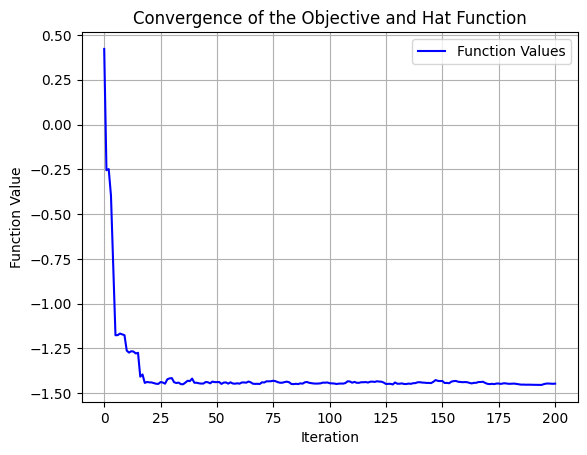

In [20]:
initial_theta  = np.random.rand(num_generators)*2*np.pi

num_iterations=200
sigma = 0.1

best_point, function_values, hat_function_values = oicd(f, generators_dict, initial_theta, num_iterations, sigma,
                             opt_goal='min', 
                             cyclic_mode=False, 
                             subproblem_iter=100,
                             )

import matplotlib.pyplot as plt

# Assuming function_values and hat_function_values are lists or arrays of objective function values
plt.plot(function_values, label='Function Values', color='b')
# plt.plot(hat_function_values, label='Hat Function Values', color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Convergence of the Objective and Hat Function')

# Adding a legend to differentiate the two curves
plt.legend()

# Show grid for easier visualization
plt.grid(True)

# Show the plot
plt.show()
